In [26]:
import jax
import jax.nn
import numpy as np
import numpyro
import optax
from numpyro.handlers import block, trace, seed
from jax import random, vmap
import matplotlib.pyplot as plt
from numpyro.infer import Predictive

In [2]:
%load_ext autoreload
%autoreload 2

from experiments.src.experiment import *
from experiments.src.data import *
from experiments.src.model import BNNRegressor

In [4]:
class BimodalData(Data):
    def __init__(self, sigma_obs=0.05, train_size=100, test_size=500, D_X=2):
        np.random.seed(0)
        self.D_X = D_X
        self.X_train = self._feature_expand(jnp.linspace(-1, 1, train_size))
        self.Y_train = np.random.choice([-1., 1.], size=(train_size, 1))
        self.Y_train += np.random.normal(scale=sigma_obs, size=(train_size, 1))

        self.X_test = self._feature_expand(jnp.linspace(-1, 1, test_size))
        self.Y_test = np.random.choice([-1.01, 1.01], size=(test_size, 1))
        self.Y_test += np.random.normal(scale=sigma_obs, size=(test_size, 1))

    def _feature_expand(self, X: jax.Array) -> jax.Array:
        return jnp.power(X[:, jnp.newaxis], jnp.arange(self.D_X))

    @property
    def train(self) -> tuple[jax.Array, jax.Array]:
        return self.X_train, self.Y_train

    @property
    def test(self) -> tuple[jax.Array, Optional[jax.Array]]:
        return self.X_test, self.Y_test

    def true_predictive(self, X: jax.Array) -> dist.Distribution:
        raise NotImplementedError()

In [96]:
data = BimodalData(D_X=2, train_size=1000)

In [18]:
%matplotlib inline
# import matplotlib
# matplotlib.use("nbAgg")  # noqa: E402

plt.rcParams.update({
    "axes.grid": True,  # show grid by default
    "font.weight": "bold",  # bold fonts
    "xtick.labelsize": 15,  # large tick labels
    "ytick.labelsize": 15,  # large tick labels
    "lines.linewidth": 1,  # thick lines
    "lines.color": "k",  # black lines
    # "grid.color": "0.5",    # gray gridlines
    "grid.linestyle": "-",  # solid gridlines
    "grid.linewidth": 0.1,  # thin gridlines
    "savefig.dpi": 300,  # higher resolution output.
})

In [106]:
DEVICE = "cpu"
numpyro.set_platform(DEVICE)
# numpyro.set_host_device_count(NUM_CHAINS)
BNN_SIZE = [16]#, 32, 64, 128, 64, 32, 16, 8]
VI_ITER = 100_000

In [107]:
bnn = BNNRegressor(
    nonlin=jax.nn.relu,
    D_X=2,
    D_Y=1,
    D_H=BNN_SIZE,
    biases=True,
    obs_model=1 / 0.05 ** 2,
    prior_scale=np.sqrt(2),
    prior_type='xavier',
)
bnn.get_weight_dim()

65

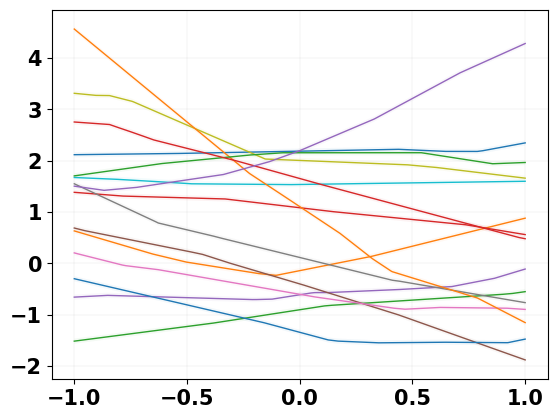

In [108]:
# For prior:
ndraws = 15
fig, ax = plt.subplots()
t = data.test[0][:, 1]

with seed(rng_seed=random.PRNGKey(1)):
    for _ in range(ndraws):
        prior_fn = trace(bnn).get_trace(X=data.test[0], Y=None)
        mu = prior_fn['Y_mean']['value'].squeeze()
        sigma = prior_fn['sigma_obs']['value'].squeeze()
        ax.plot(t, mu)
        ax.fill_between(t, mu - sigma, mu  + sigma, alpha=0.05)

plt.show()

In [86]:
delta = AutoDeltaVIExperiment(bnn, data, max_iter=VI_ITER, lr_schedule=optax.constant_schedule(-0.01))

In [87]:
delta.train(random.PRNGKey(500_000))

Initial eval loss: 578392320.0000 (lik: -578390272.0000, kl: 2058.0303)


100%|██████████| 50/50 [00:46<00:00,  1.08it/s, init loss: 578392320.0000, avg. train loss / eval. loss [98000-100000]: 2952.8240 / 2952.5986]  


SVI elapsed time: 46.551992893218994


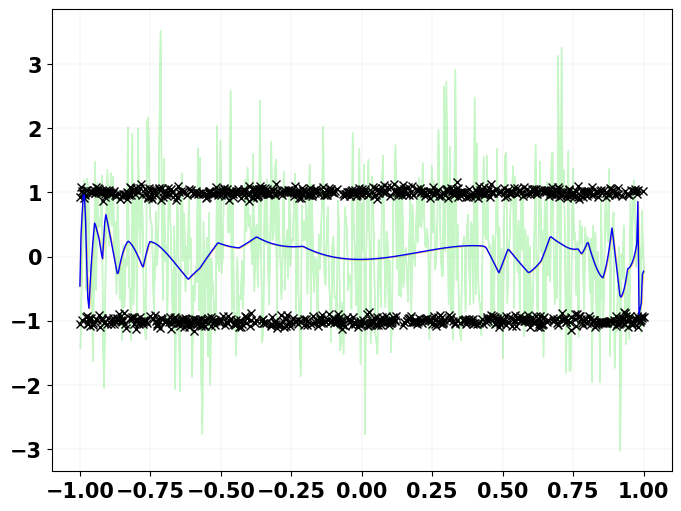

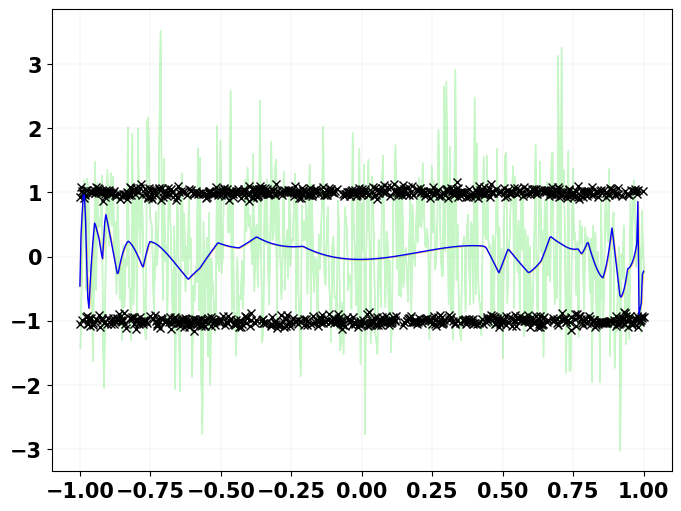

In [88]:
delta.make_predictions(random.PRNGKey(1))
delta.make_plots()

In [89]:
map_predictive_mean = delta._predictions['Y_mean'][0]
map_mse = jnp.mean(jnp.square(map_predictive_mean - data.test[1]))
map_mse

DeviceArray(1.0528314, dtype=float32)

In [77]:
hmc = BasicHMCExperiment(bnn, data, num_warmup=400, num_samples=200, num_chains=1)

sample: 100%|██████████| 600/600 [00:22<00:00, 27.26it/s, 1023 steps of size 2.99e-04. acc. prob=0.97]



MCMC elapsed time: 24.466891050338745


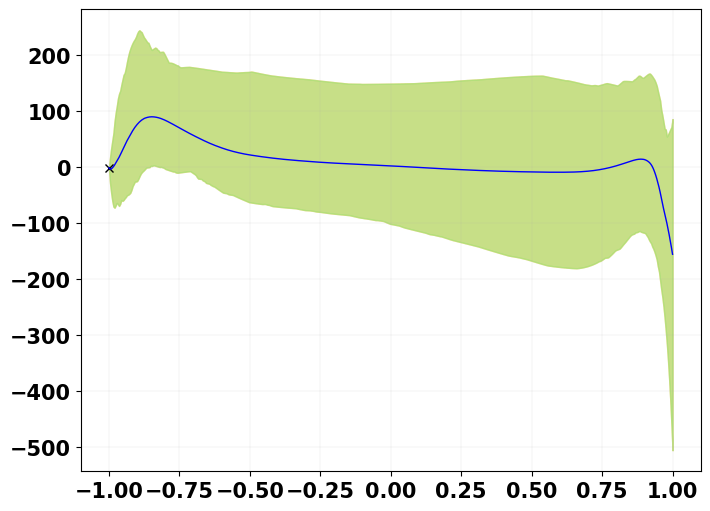

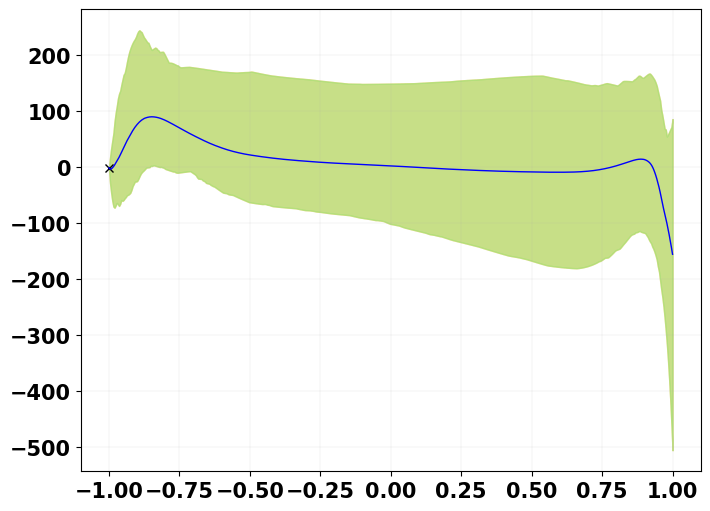

In [78]:
hmc.run(random.PRNGKey(0))

In [79]:
hmc_mse = jnp.mean(jnp.square(hmc._predictions['Y_mean'].mean(axis=0) - data.test[1]))
hmc_mse

DeviceArray(1169.8939, dtype=float32)

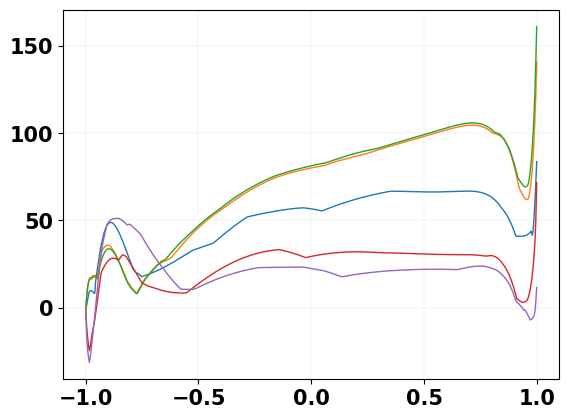

In [80]:
fig, ax = plt.subplots()

t = data.test[0][:, 1]

for i in range(-6, -1):
    mu = hmc._predictions['Y_mean'][i, :, 0]
    sigma = hmc._predictions['sigma_obs'][i]
    ax.plot(t, mu)
    ax.fill_between(t, mu - sigma, mu + sigma, alpha=0.05)

# ax.set_ylim(-2, 2)

plt.show()

# HMC as we add more data

In [23]:
DATA_SIZES = [1, 2, 5, 10, 25, 50, 100, 200, 1000]

In [24]:
datas = [BimodalData(train_size=size, D_X=50) for size in DATA_SIZES]

sample: 100%|██████████| 600/600 [00:20<00:00, 28.86it/s, 665 steps of size 1.38e-03. acc. prob=0.69] 



MCMC elapsed time: 21.133452892303467


sample: 100%|██████████| 600/600 [00:46<00:00, 12.94it/s, 1023 steps of size 5.50e-04. acc. prob=0.95]



MCMC elapsed time: 48.302733182907104


sample: 100%|██████████| 600/600 [00:40<00:00, 14.71it/s, 1023 steps of size 1.73e-03. acc. prob=0.79]



MCMC elapsed time: 42.24320197105408


sample: 100%|██████████| 600/600 [00:37<00:00, 16.09it/s, 1023 steps of size 9.25e-04. acc. prob=0.80]



MCMC elapsed time: 38.33963489532471


sample: 100%|██████████| 600/600 [00:39<00:00, 15.16it/s, 1023 steps of size 2.39e-03. acc. prob=0.83]



MCMC elapsed time: 40.73698711395264


sample: 100%|██████████| 600/600 [00:37<00:00, 16.04it/s, 1023 steps of size 2.32e-03. acc. prob=0.84]



MCMC elapsed time: 38.301156997680664


sample: 100%|██████████| 600/600 [00:40<00:00, 14.90it/s, 1023 steps of size 2.13e-03. acc. prob=0.84]



MCMC elapsed time: 40.55379796028137


sample: 100%|██████████| 600/600 [01:02<00:00,  9.61it/s, 1023 steps of size 1.95e-03. acc. prob=0.85]



MCMC elapsed time: 63.348706007003784


sample: 100%|██████████| 600/600 [04:29<00:00,  2.22it/s, 1023 steps of size 1.41e-03. acc. prob=0.87]



MCMC elapsed time: 271.0688638687134


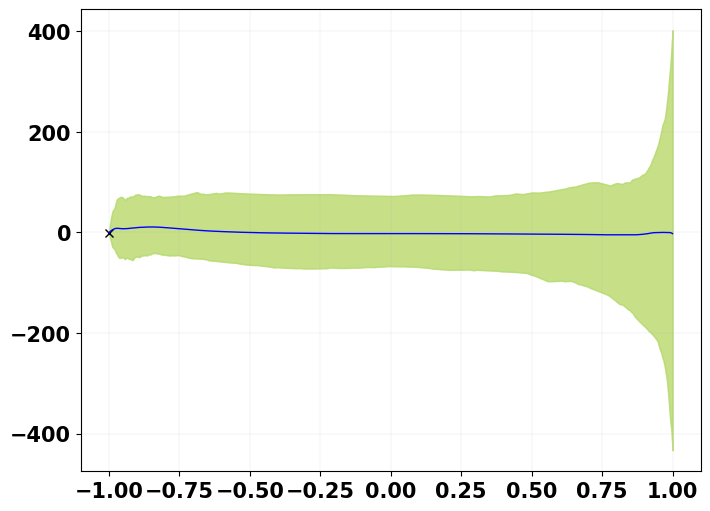

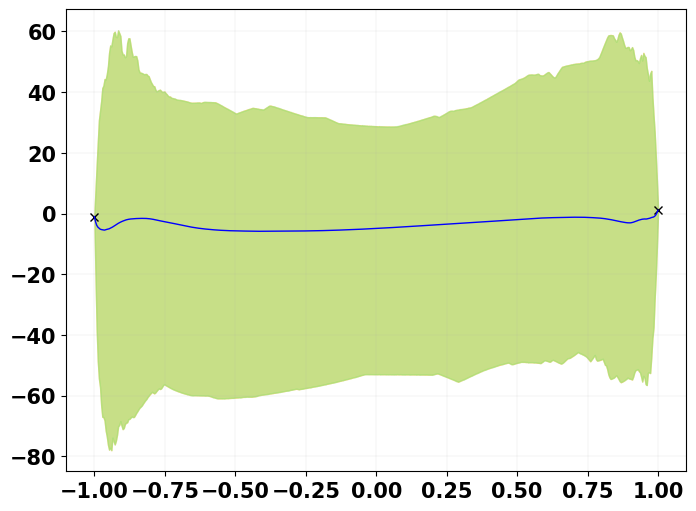

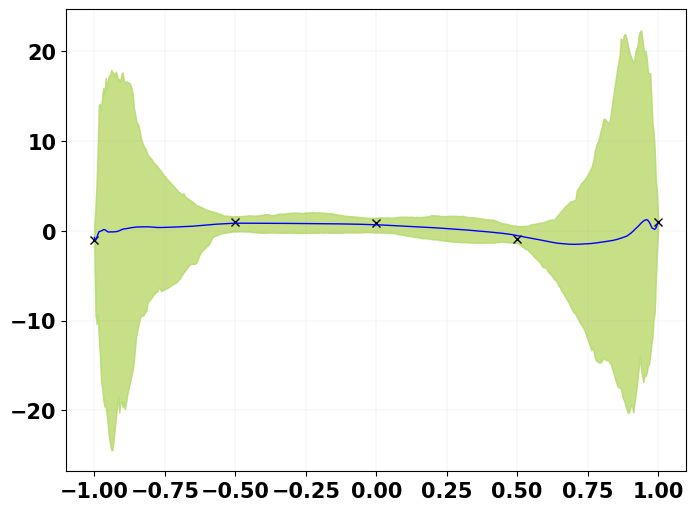

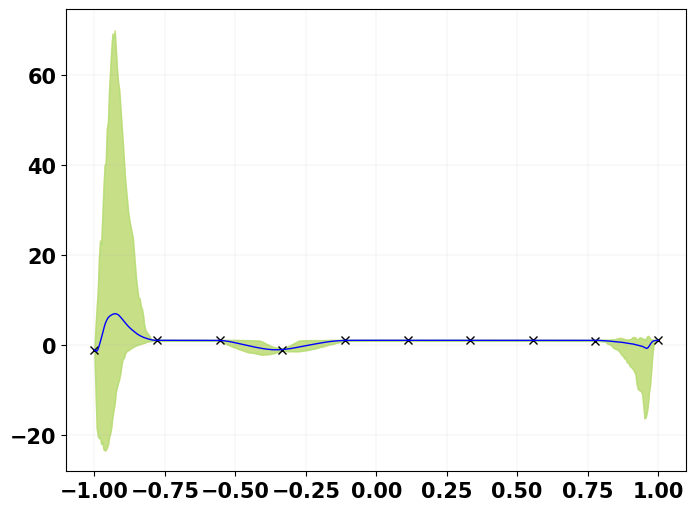

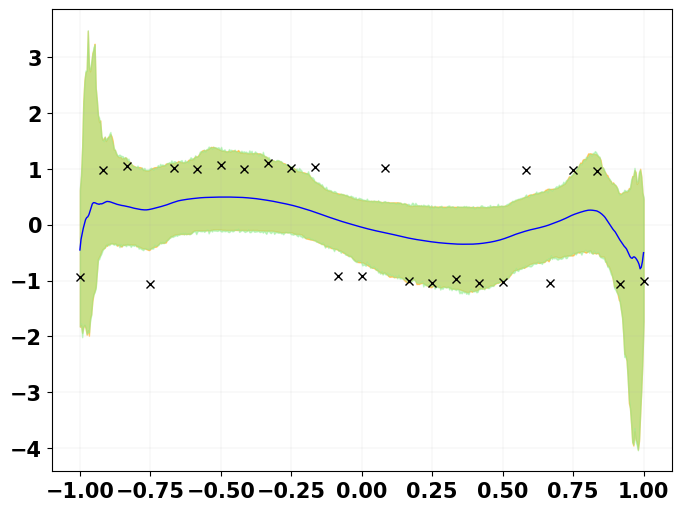

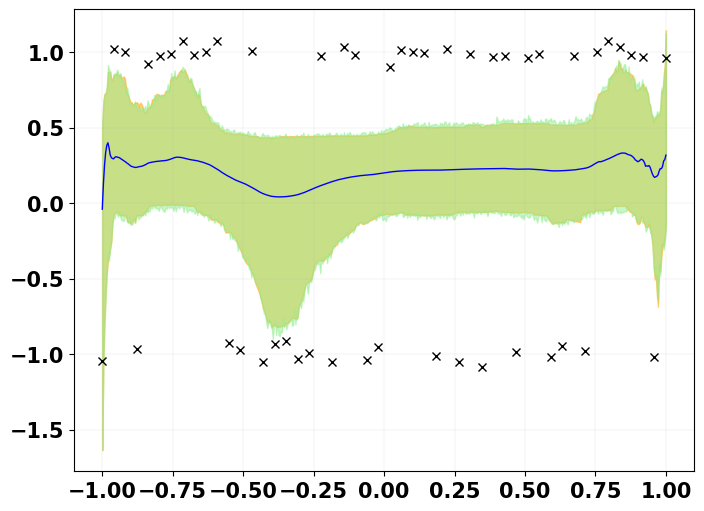

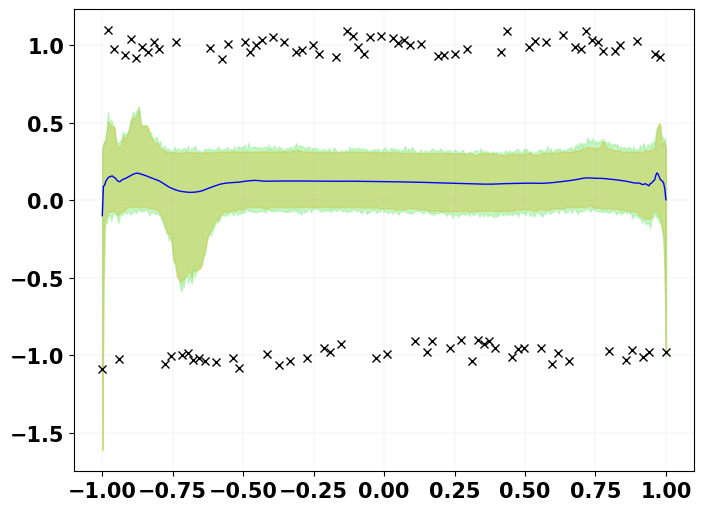

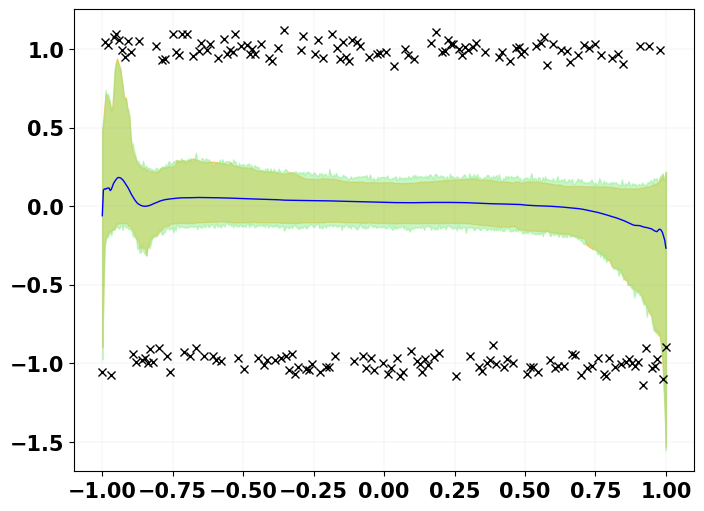

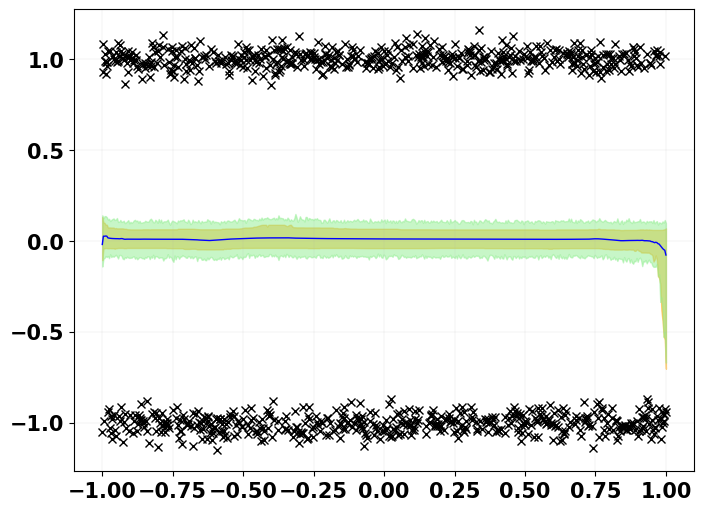

In [81]:
mses = dict()
for data_instance in datas:
    hmc_instance = BasicHMCExperiment(bnn, data_instance, num_samples=300, num_warmup=300)
    hmc_instance.train(random.PRNGKey(0))
    predictions = Predictive(
        bnn, hmc_instance._samples, return_sites=['Y_mean'])(
        random.PRNGKey(1), X=data_instance.test[0], Y=None)
    mean_predictions = predictions['Y_mean'].mean(axis=0)
    mse = jnp.mean(jnp.square(mean_predictions - data_instance.test[1]))
    mses[data_instance.train[0].shape[0]] = mse
    hmc_instance.make_predictions(random.PRNGKey(1))
    hmc_instance.make_plots()

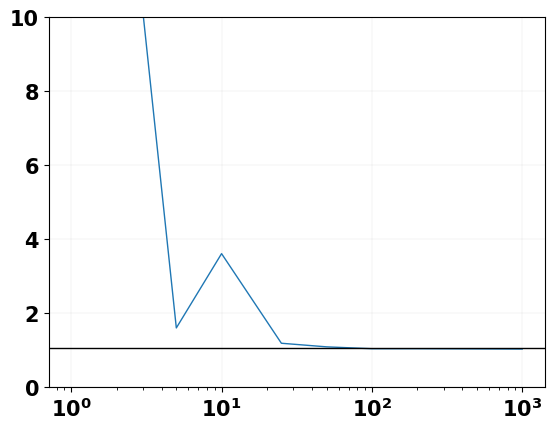

In [91]:
fig, ax = plt.subplots()
ax.plot(mses.keys(), mses.values())
ax.axhline(y=map_mse)
ax.set_ylim(0, 10)
ax.set_xscale('log')
plt.show()